# Introduction
This project presents a study about how hyperparameters like the **number of convolutional layers** or the **kernel size** may affect the neural network performance. 

Regarding the number of layers, their relevance is something to take into account, since an oversized or undersized network will lead to overfitting or underfitting and high computing time.

Kernel size has an important role as well.The kernel size will define the dimensions of the convolution result. Lowering this hyperparameter implies an improval on the computation time, but also provides a more basic generalization level.

The study consists in analyzing the results of the training and evaluation of several architectures with the same dataset, each one different from the other. The experiment finishes with the conclusions obtained from this 
data.



This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset. This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


# Metholodogy

First of all, the input of the network will be a 28x28 image corresponding to one digit. This image will pass through a convolutional layer with 20 square kernels, each one with size 5x5 and a stride equals to 1. 

After the convolution process, ReLU function is applied to the output. Then pooling is used to reduce the number of the network features and to ease the whole process reducing computation cost and time. 

Secondly, the last block is repeated, but its input will be the previous block’s output. The difference is the number kernels of the second layer, 50 in this case. 

The result of the previous operations is a 4x4 matrix with a 50 channels depth. This means that right now the number of parameters is 800. The usage of the two fully connected layers allows us to reduce this number to the 10 possible outputs.

In order to evaluate this system with different hyperparameters, we have designed and trained 9 different networks and we have drawn conclusions based on the comparison of the results given, such as loss, accuracy and execution time.



In [1]:
!pip install pillow==5.4.1
!pip install matplotlib 
!pip install scikit-learn
!pip install torch
!pip install torchvision

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

We create a class which extends nn.Module and takes a list of modules as input of the __init__() method to create a ModuleList. 
Forward function concatenates all previous layers and adds a softmax function at the end.

In [0]:
class Net(nn.Module):
    def __init__(self, layers):
      super(Net, self).__init__() 
      self.layers = nn.ModuleList(layers)

    def forward(self, x):
      for _,l in enumerate(self.layers):
        x = l(x)
      return F.log_softmax(x, dim=1)

Flatten class to reshape the values and be able to append it to the list of modules.

In [0]:
class Flatten(nn.Module):
  def forward(self,x):
    x = x.view(-1, x.size()[1]*x.size()[2]*x.size()[3] )
    return x

Result class to store the data collected from training (model, validation loss, train loss, time)

In [0]:
class Result():
  def __init__(self, net, train_loss, val_loss, time):
    self.net        = net
    self.train_loss = train_loss
    self.val_loss   = val_loss
    self.time       = time

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        start_time = time.time()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

In [9]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

Processing...
Done!


In [0]:
nets = []

Net 0 is set as the default net with 2 convolution layers. The first one, 5x5 kernel size, stride = 1, no padding and 1 channel in to 20 out.
The second one has a 5x5 kernel size, stride = 1, no padding and 20 channel in to 50 out.

In [0]:
net0 = [nn.Conv2d(1,20,5,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(20,50,5,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(4*4*50,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net0)

Net1 has 2 conv2d layers with 3x3 kernels size with the same stride as Net 0 (stride = 1) and adding padding = 1. Same number of channels in/out than Net0.

In [0]:
net1 = [nn.Conv2d(1,20,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(20,50,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(7*7*50,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net1)

Net2 has 2 conv2d layers. First kernel size of 5x5 and another one 3x3 kernel with the same stride as Net1 (stride = 1) and no padding = 0. Same number of channels in/out than Net0.

In [0]:
net2 = [nn.Conv2d(1,20,5,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(20,50,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(5*5*50,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net2)

Net3 has 2 conv2d layers. The first kernel size of 3x3 with padding = 1 and another one 5x5 kernel with both stride = 1. Same number of channels in/out than Net0.

In [0]:
net3 = [nn.Conv2d(1,20,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(20,50,5,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(5*5*50,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net3)

Net4 has an only conv2d layer with a kernel size of 7x7 with stride = 3, no padding and 1 channel in, 20 out.

In [0]:
net4 = [nn.Conv2d(1,20,7,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(4*4*20, 200),
        nn.ReLU(),
        nn.Linear(200,10)]
nets.append(net4)

Net 5 has only one channel, a kernel size of 13x13 and a stride = 5. No padding. The reason of this parameters is trying to underfit the dataset.

In [0]:
 net5 = [nn.Conv2d(1,1,13,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(2*2*1,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net5)

Net 6 has a 5x5 kernel size with a stride = 3 in order to compare with the net above. No padding and a Maxpool.

In [0]:
net6 = [nn.Conv2d(1,20,5,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(4*4*20,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net6)

Net 7 has a 13x13 kernel size, stride = 3 and only 2 channel out to obtain an underfitting. No padding and one Maxpool.

In [0]:
net7 = [nn.Conv2d(1,2,13,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        Flatten(),
        nn.Linear(3*3*2,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net7)

Net 8 has 5 conv2d layers. All set with a 3x3 kernel size, stride = 1 and no padding. There are 2 MaxPools in order to reduce computational cost.

In [0]:
net8 = [nn.Conv2d(1,20,3,1),
        nn.ReLU(),
        nn.Conv2d(20,50,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(50,50,3,1),
        nn.ReLU(),
        nn.Conv2d(50,50,3,1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(50,80,3,1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(2*2*80,500),
        nn.ReLU(),
        nn.Linear(500,10)]
nets.append(net8)

Train the different nets and we store all the results in order to plot them later.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
results = {}
for i,m in enumerate(nets):
  print( "------ Net " + str(i) + " ------" )
  start_time = time.time()
  model = None
  optimizer = None
  model = Net(m).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      start_time_epoch = time.time()
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      print("Training time: " + str(time.time()-start_time_epoch))
      valid_loss = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)
  
  total_time = time.time()-start_time
  results['net'+str(i)] = Result(model, train_losses, valid_losses, total_time)
  
  print("Total time: " + str(total_time))
  #plt.gcf().clear()
  #plt.plot(train_losses, 'b-')
  #plt.plot(valid_x, valid_losses, 'r-')
  #plt.show()

------ Net 0 ------
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301021
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.603702
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.433208
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.459860
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.370031
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.221789
Training time: 66.99132561683655

Validation set: Average loss: 0.1676, Accuracy: 9504/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.208918
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.337949
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.139071
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.103127
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.127151
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.087134
Training time: 66.75278329849243

Validation set: Average loss: 0.0949, Accuracy: 9730/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.094088
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.067026
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.062841
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.04

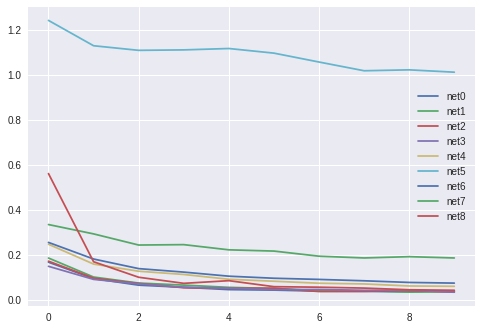


 Execution times: 

{'net0': 709.0290424823761, 'net1': 868.5447900295258, 'net2': 651.9426295757294, 'net3': 901.8696768283844, 'net4': 168.13677144050598, 'net5': 148.22037768363953, 'net6': 172.83531165122986, 'net7': 159.22188687324524, 'net8': 2247.9229934215546}


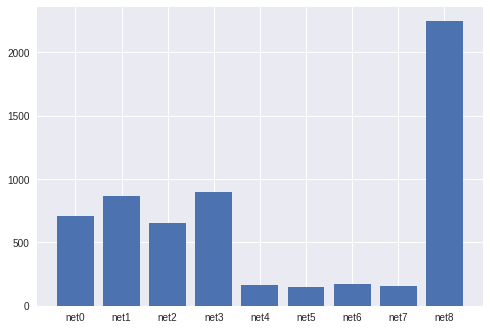

In [21]:
plt.gcf().clear()
times = {}
for key in results:
  plt.plot( results[key].val_loss, label=key )
  plt.legend()
  times[key]=results[key].time

plt.show()
print("\n Execution times: \n")
print(times)

plt.bar(range(len(times)), list(times.values()))
plt.xticks(range(len(times)), list(times.keys()))
plt.show()

# Conclusions

Firstly, the dependance on the dataset, more exactly, on the images size, and the number of possible labels was a limitation. The dataset used, MNIST, has 28x28 images. Each convolutional layer of the network reduces the size of its input, so we were not able to add as many convolutional layers as we intended to.

The images provided by the dataset are very simple. They only have dark colors and ten possible outputs, so the usage of really complex network architectures did not make sense in this experiment.

However, the results of training the different models lead us to conclude the following:


1.   When the **number of layers** is big, the training and validation time is exponentially increased, nevertheless, the accuracy does not increase as much as what we would consider worth.
2.   The **kernel size** is also directly related to the time, but not the accuracy. We observed that even though time highered, it costed less than adding lots of layers. 
3. The tests performed on the **stride** were not conclusive due to the simplicity of the dataset.





